# Exploring Dandiset 001375: Septum GABA Disruption with DREADDs

**Notebook generated with the assistance of AI. Please use caution and verify results as needed.**

---

## Overview

This notebook introduces and explores [Dandiset 001375](https://dandiarchive.org/dandiset/001375/0.250406.1855), a pilot electrophysiology dataset investigating the effect of disrupting septal GABAergic activity using DREADDs on hippocampal and neocortical activity in mice.

The notebook walks through:
- Accessing NWB files from the Dandiset using the DANDI Python API
- Exploring the structure and main data groups of an NWB file
- Visualizing raw broadband electrophysiology data
- Plotting spike rasters for all detected units
- Displaying electrode metadata
- Examining trial interval information

By the end, you should understand the data types present, how to access them, and how to get started with your own analyses.

---

## What This Notebook Covers

- Dandiset and data overview
- Required Python packages
- Listing and selecting NWB files
- Streaming and inspecting NWB file contents
- Visualizing raw signals and spike times
- Summarizing electrode and trial metadata
- Code and explanations for further analysis

---

## Required Packages

This notebook requires the following Python packages (assume already installed):
- `dandi`
- `pynwb`
- `remfile`
- `h5py`
- `matplotlib`
- `numpy`
- `pandas`

No pip installation commands are included.

---

In [1]:
# Import core libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dandi.dandiapi import DandiAPIClient
import pynwb
import remfile
import h5py

## Accessing the Dandiset and Listing NWB Files

First, we'll use the DANDI Python API to connect to Dandiset 001375 and list the available NWB files. This helps you discover what recording sessions and subjects are present.


In [2]:
# Set Dandiset ID and version
dandiset_id = "001375"
dandiset_version = "0.250406.1855"

# Connect to the DANDI API
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List all NWB files in this Dandiset
nwb_files = [
    asset.path
    for asset in dandiset.get_assets()
    if asset.path.endswith('.nwb')
]

print("Available NWB files in Dandiset 001375:")
for path in nwb_files:
    print("-", path)

Available NWB files in Dandiset 001375:
- sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb


## Selecting an NWB File for Exploration

We'll focus on the first NWB file as a case study:
- `sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb`

(You can modify the code to explore other files in the list.)

In [3]:
# Select the file to explore
nwb_path = nwb_files[0]
print(f"Selected NWB file: {nwb_path}")

Selected NWB file: sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb


## Remotely Streaming and Loading the NWB File

We'll stream the NWB file from the DANDI archive using `remfile` and open it directly with `pynwb` (via `h5py`) without downloading the full file.

In [4]:
# Locate and stream the NWB file
asset = next(dandiset.get_assets_by_glob(nwb_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## High-Level Summary of the NWB File

Let's examine the main file attributes and top-level data groups to get an overview of the session contents.

In [5]:
print("Session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("Subject ID:", nwb.subject.subject_id)
print("Subject description:", nwb.subject.description)
print("File identifier:", nwb.identifier)

print("\nMain available fields/groups:")
print("acquisition:", list(nwb.acquisition.keys()))
print("electrode_groups:", list(nwb.electrode_groups.keys()))
print("devices:", list(nwb.devices.keys()))
print("intervals:", list(nwb.intervals.keys()))
print("electrodes columns:", nwb.electrodes.colnames)
print("units columns:", nwb.units.colnames)
print("trials columns:", nwb.trials.colnames)

Session description: mouse running laps in virtual hallway
Session start time: 2024-07-25 19:00:00-07:00
Subject ID: MS13B
Subject description: medial septum DREADD to suppress GABA interneurons
File identifier: MS13B

Main available fields/groups:
acquisition: ['time_series']
electrode_groups: ['shank1', 'shank2']
devices: ['silicon probe array']
intervals: ['trials']
electrodes columns: ('x', 'y', 'location', 'filtering', 'group', 'group_name', 'label')
units columns: ('spike_times',)
trials columns: ('start_time', 'stop_time')


## Visualizing Raw Electrophysiology: First 5 Seconds, Single Channel

The raw electrophysiological signals are stored as a time series array across channels (shape: samples × channels, sampling rate: 30 kHz).

Below, we plot 5 seconds from channel 0 to inspect the data quality and typical voltage fluctuations.

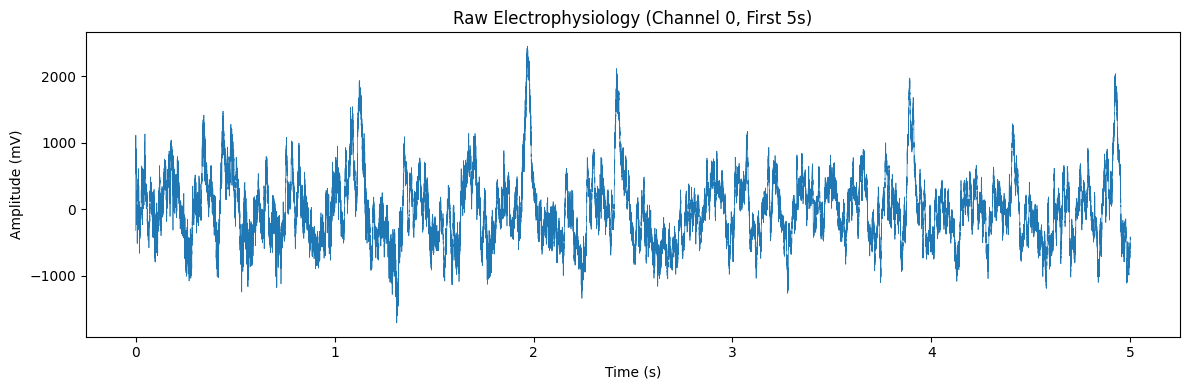

In [6]:
# Parameters
channel_idx = 0  # Plot channel 0
segment_seconds = 5

# Access the time series data
ts = nwb.acquisition['time_series']
sample_rate = ts.rate
n_samples = int(segment_seconds * sample_rate)

# Retrieve a short segment for the selected channel
data_segment = ts.data[:n_samples, channel_idx]
time = (1 / sample_rate) * np.arange(n_samples)

# Convert to appropriate units if conversion factor exists
if hasattr(ts, 'conversion'):
    data_segment = data_segment * ts.conversion

# Plot the raw trace
plt.figure(figsize=(12, 4))
plt.plot(time, data_segment, lw=0.5)
plt.title(f'Raw Electrophysiology (Channel {channel_idx}, First {segment_seconds}s)')
plt.xlabel('Time (s)')
plt.ylabel(f'Amplitude ({ts.unit})')
plt.tight_layout()
plt.show()

## Visualizing Spike Rasters for All Units (First 60 Seconds)

The NWB file contains a unit table with spike times for 33 detected neurons ("units"). Below, we plot a spike raster for all units over the first 60 seconds for a population overview.

**Note:** In this NWB file, the correct way to access spike times is to iterate over `nwb.units.spike_times_index[i]` for each unit `i`.

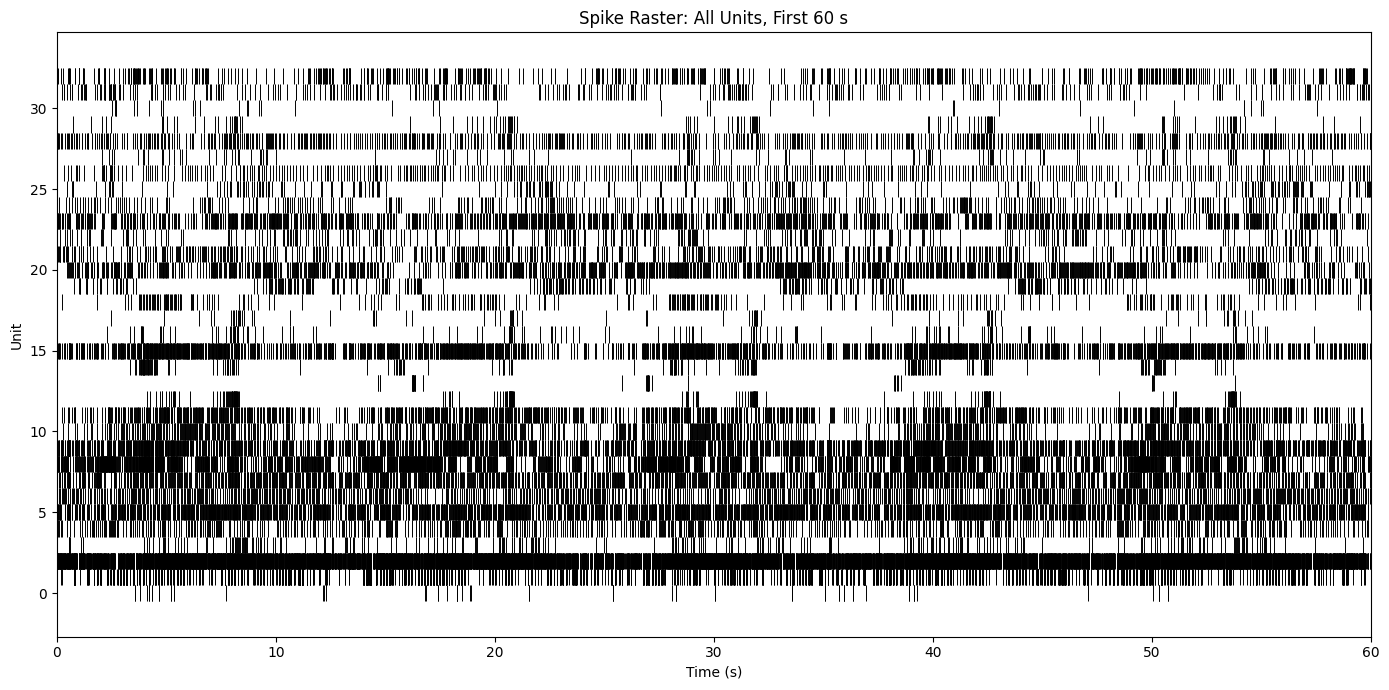

In [7]:
interval_seconds = 60  # Time window for raster

num_units = len(nwb.units)
raster_times = []
for i in range(num_units):
    # Access spike times for unit i
    unit_spikes = nwb.units.spike_times_index[i]
    in_window = unit_spikes[(unit_spikes >= 0) & (unit_spikes < interval_seconds)]
    raster_times.append(in_window)

plt.figure(figsize=(14, 7))
plt.eventplot(raster_times, colors='k', linewidths=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.title('Spike Raster: All Units, First 60 s')
plt.xlim(0, interval_seconds)
plt.tight_layout()
plt.show()

## Examining Electrode Metadata

The file contains metadata for all 256 electrode channels, including location, grouping (shank1/shank2), and positional indices.

Below, we display key columns (`x`, `y`, `location`, `group`, `label`) for all electrodes. This can help you link spike data to electrode/channel locations and probe layout.

In [8]:
# Convert the electrode metadata table to a pandas DataFrame
columns_to_display = ['x', 'y', 'location', 'group', 'label']
electrodes_df = nwb.electrodes.to_dataframe()[columns_to_display]

# Display the first few and last few rows as a summary
display_rows = pd.concat([electrodes_df.head(5), electrodes_df.tail(5)])
print(display_rows)
print(f"\nTotal electrodes: {len(electrodes_df)}")

        x       y location                                              group  \
id                                                                              
0    20.0  1375.0  unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x13594...   
1    20.0  1325.0  unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x13594...   
2    20.0  1275.0  unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x13594...   
3    20.0  1225.0  unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x13594...   
4    20.0  1175.0  unknown  shank1 pynwb.ecephys.ElectrodeGroup at 0x13594...   
251 -20.0  1575.0  unknown  shank2 pynwb.ecephys.ElectrodeGroup at 0x13594...   
252 -20.0  1525.0  unknown  shank2 pynwb.ecephys.ElectrodeGroup at 0x13594...   
253 -20.0  1475.0  unknown  shank2 pynwb.ecephys.ElectrodeGroup at 0x13594...   
254 -20.0  1425.0  unknown  shank2 pynwb.ecephys.ElectrodeGroup at 0x13594...   
255 -20.0  1375.0  unknown  shank2 pynwb.ecephys.ElectrodeGroup at 0x13594...   

                   label  


## Viewing Trials Table: Start and Stop Times

This experiment includes 387 “trials” (laps) with precise start and stop times.

The table below shows the timing for the first several trials:


In [9]:
# Extract trial start/stop times
trials_df = nwb.trials.to_dataframe()[['start_time', 'stop_time']]
print(trials_df.head())
print(f"... (total {len(trials_df)} trials)")

    start_time  stop_time
id                       
0     4.323800  16.929833
1    16.963067  28.414333
2    28.447100  39.402833
3    39.435833  50.027033
4    50.059667  63.064467
... (total 387 trials)


## Recap and Next Steps

**Summary:**  
- Explored [Dandiset 001375](https://dandiarchive.org/dandiset/001375/0.250406.1855) and listed all available NWB files.
- Accessed and streamed a session NWB file using DANDI tools.
- Visualized raw ephys signals and spike rasters for neuronal units.
- Examined electrode metadata and trial interval information.

**Next steps for further analysis might include:**
- Linking spike or LFP patterns to trial structure or behavior
- Filtering or referencing data to investigate oscillations or events
- Comparing activity between shanks, channels, or units
- Visualizing or clustering unit waveforms

**Tip:**  
All code shown can be adapted to other files or modified for more complex analyses.

For questions about the Dandiset or technical help, consult the [DANDI documentation](https://www.dandiarchive.org/) or file an issue on GitHub.

---